In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load data
train = pd.read_csv('../data/train.csv')
train_updates = pd.read_csv("../data/train_updates_20220929.csv")
test = pd.read_csv("../data/test.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")
train.update(train_updates)

# data info
print("\ntrain info")
print(train.info())
print("\ntrain head")
print(train.head())
print("\ntrain describe")
print(train.describe())
print("\n null values in train data")
print(train.isnull().sum())



train info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31390 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            31390 non-null  int64  
 1   protein_sequence  31390 non-null  object 
 2   pH                31104 non-null  float64
 3   data_source       28043 non-null  object 
 4   tm                31390 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB
None

train head
   seq_id                                   protein_sequence   pH  \
0      69  AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0   
1      70  AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0   
2      71  AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0   
3      72  AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...  7.0   
4      73  AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...  7.0   

                         data_source    tm  
0  doi.org/1

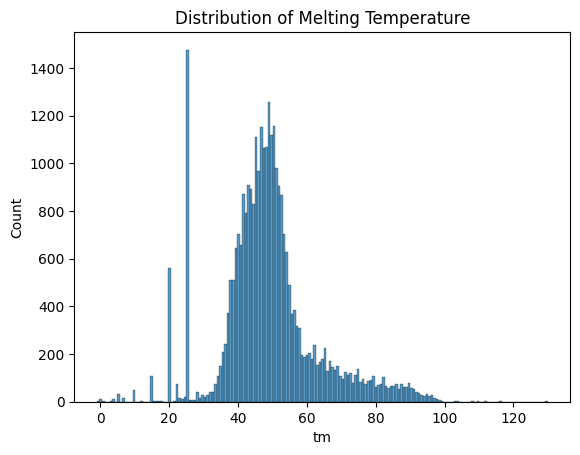

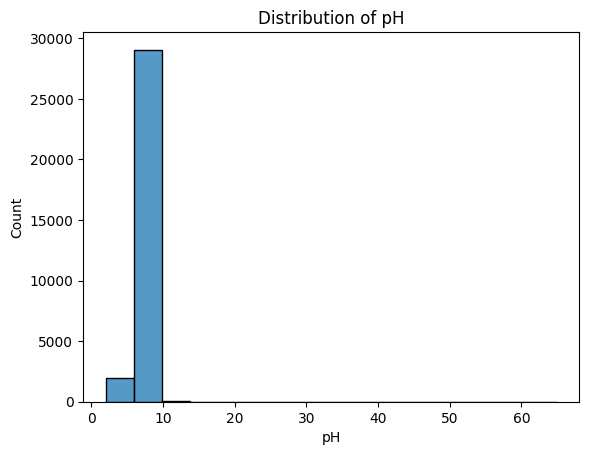

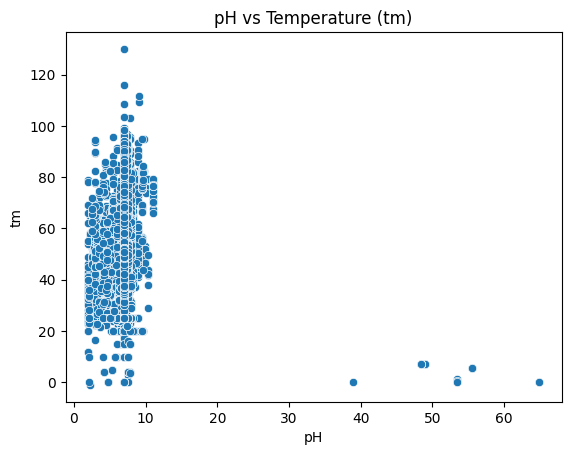

In [2]:
# distribution of tm
plt.figure()
sns.histplot(train["tm"])
plt.title("Distribution of Melting Temperature")
plt.show()

# distribution of pH
plt.figure()
sns.histplot(train["pH"])
plt.title("Distribution of pH")
plt.show()

# tm vs pH
plt.figure()
sns.scatterplot(data=train, x="pH", y="tm")
plt.title("pH vs Temperature (tm)")
plt.show()

In [3]:
# drop null values
train.dropna(inplace=True)

train.drop(columns=["pH"], inplace=True)
train.drop(columns=["data_source"], inplace=True)
train.drop(columns=["seq_id"], inplace=True)


In [4]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 27769 entries, 0 to 31389
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   protein_sequence  27769 non-null  object 
 1   tm                27769 non-null  float64
dtypes: float64(1), object(1)
memory usage: 650.8+ KB
None


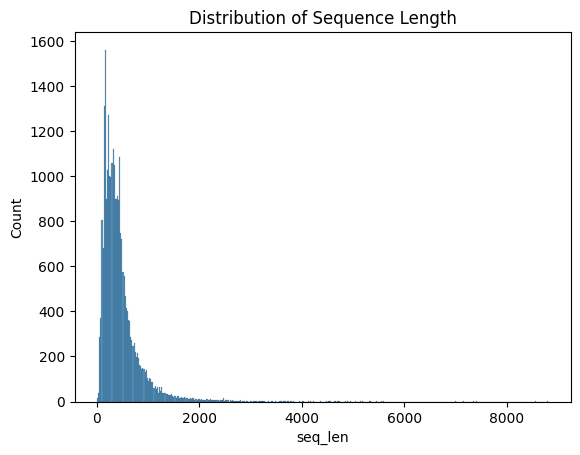

In [5]:
# sort by len if seq
train_copy = train.copy()
train_copy["seq_len"] = train_copy["protein_sequence"].apply(len)

# draw contribution of seq len
plt.figure()
sns.histplot(train_copy["seq_len"])
plt.title("Distribution of Sequence Length")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from tqdm import tqdm


def extract_protein_features(sequence):
    """从蛋白质序列中提取特征
    length: 长度f蛋白质序列的长度,即氨基酸的数量。
    weight: 分子量：蛋白质的分子量,通常以道尔顿 Dalton, Da 为单位。它是所有氨基酸残基的分子量之和。
    aromaticity: 芳香性：蛋白质中芳香族氨基酸（如苯丙氨酸、酪氨酸和色氨酸）的比例。芳香性可以影响蛋白质的吸光特性和结构稳定性。
    instability_index: 不稳定指数,预测蛋白质在体外环境中的稳定性。指数大于40的蛋白质被认为是不稳定的，小于40的蛋白质被认为是稳定的。
    isoelectric_point: 等电点,蛋白质在特定pH值下的净电荷为零的点。等电点可以影响蛋白质的溶解性和电泳行为。
    helix_fraction: 螺旋含量：蛋白质二级结构中α螺旋的比例。α螺旋是蛋白质常见的二级结构之一。
    turn_fraction: 转角含量：蛋白质二级结构中转角的比例。转角是蛋白质链中常见的二级结构元素，通常出现在链的转折处。
    sheet_fraction: 片层含量：蛋白质二级结构中β片层的比例。β片层是蛋白质常见的二级结构之一，由多个β链通过氢键相互连接形成。
    """
    try:
        analysis = ProteinAnalysis(sequence)
        return {
            "length": len(sequence),
            "weight": analysis.molecular_weight(),
            "aromaticity": analysis.aromaticity(),
            "instability_index": analysis.instability_index(),
            "isoelectric_point": analysis.isoelectric_point(),
            "helix_fraction": analysis.secondary_structure_fraction()[0],
            "turn_fraction": analysis.secondary_structure_fraction()[1],
            "sheet_fraction": analysis.secondary_structure_fraction()[2],
        }
    except Exception as e:
        print(f"Error processing sequence: {sequence}, error: {e}")
        return None


def create_feature_matrix(df):
    """为所有序列创建特征矩阵"""
    features = []
    for seq in tqdm(df["protein_sequence"]):
        feat = extract_protein_features(seq)
        features.append(feat)

    feature_df = pd.DataFrame(features)
    return feature_df

# 提取特征
X = create_feature_matrix(train)
y = train["tm"]

# 分割训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("特征矩阵形状:", X_train_scaled.shape)
print("特征列:", list(X_train.columns))


100%|██████████| 27769/27769 [00:04<00:00, 6743.89it/s]


特征矩阵形状: (22215, 8)
特征列: ['length', 'weight', 'aromaticity', 'instability_index', 'isoelectric_point', 'helix_fraction', 'turn_fraction', 'sheet_fraction']


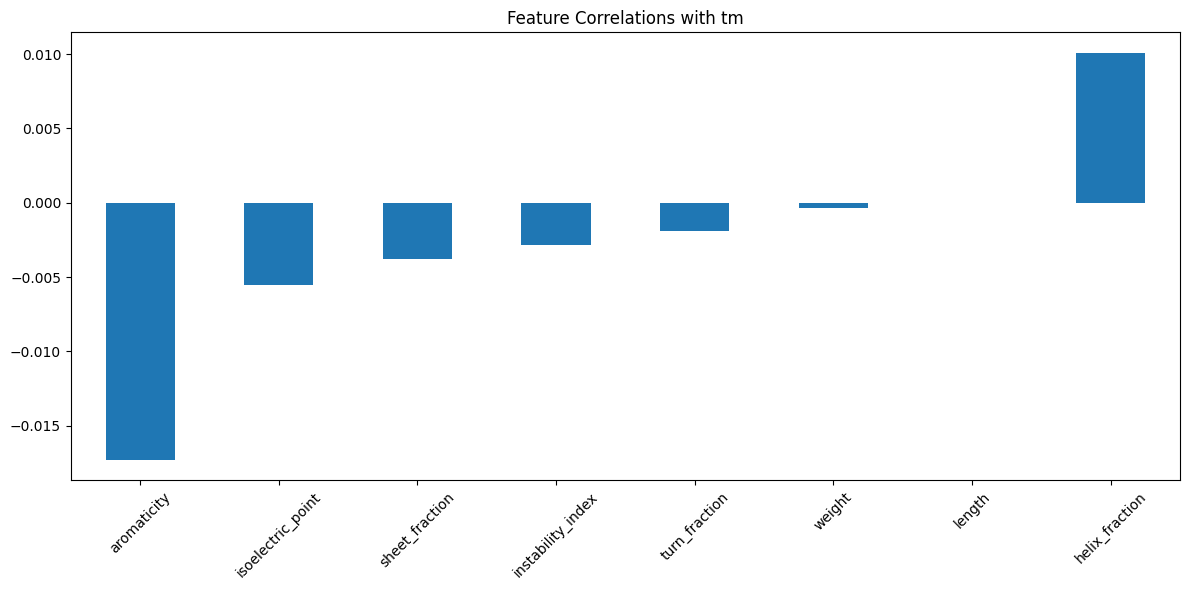

In [13]:
correlations = X.corrwith(y)
plt.figure(figsize=(12, 6))
correlations.sort_values().plot(kind="bar")
plt.title("Feature Correlations with tm")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


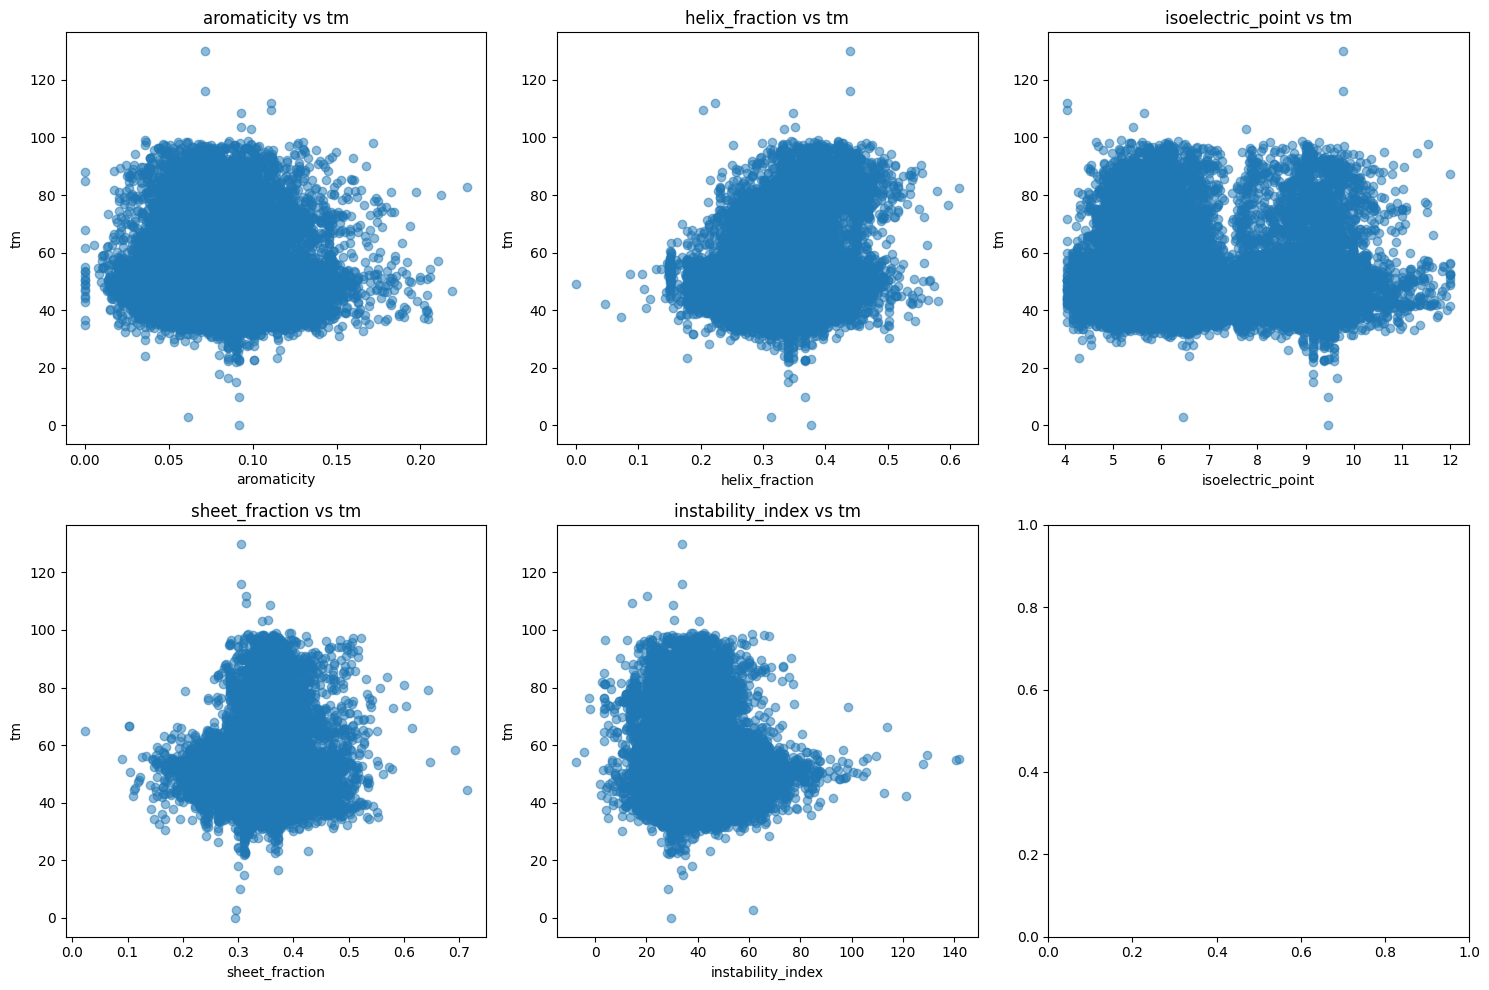

In [14]:
# 选择相关性最强的几个特征绘制散点图
top_features = correlations.abs().nlargest(5).index
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, feature in enumerate(top_features):
    ax = axes[i // 3, i % 3]
    ax.scatter(X[feature], y, alpha=0.5)
    ax.set_xlabel(feature)
    ax.set_ylabel("tm")
    ax.set_title(f"{feature} vs tm")
plt.tight_layout()
plt.show()


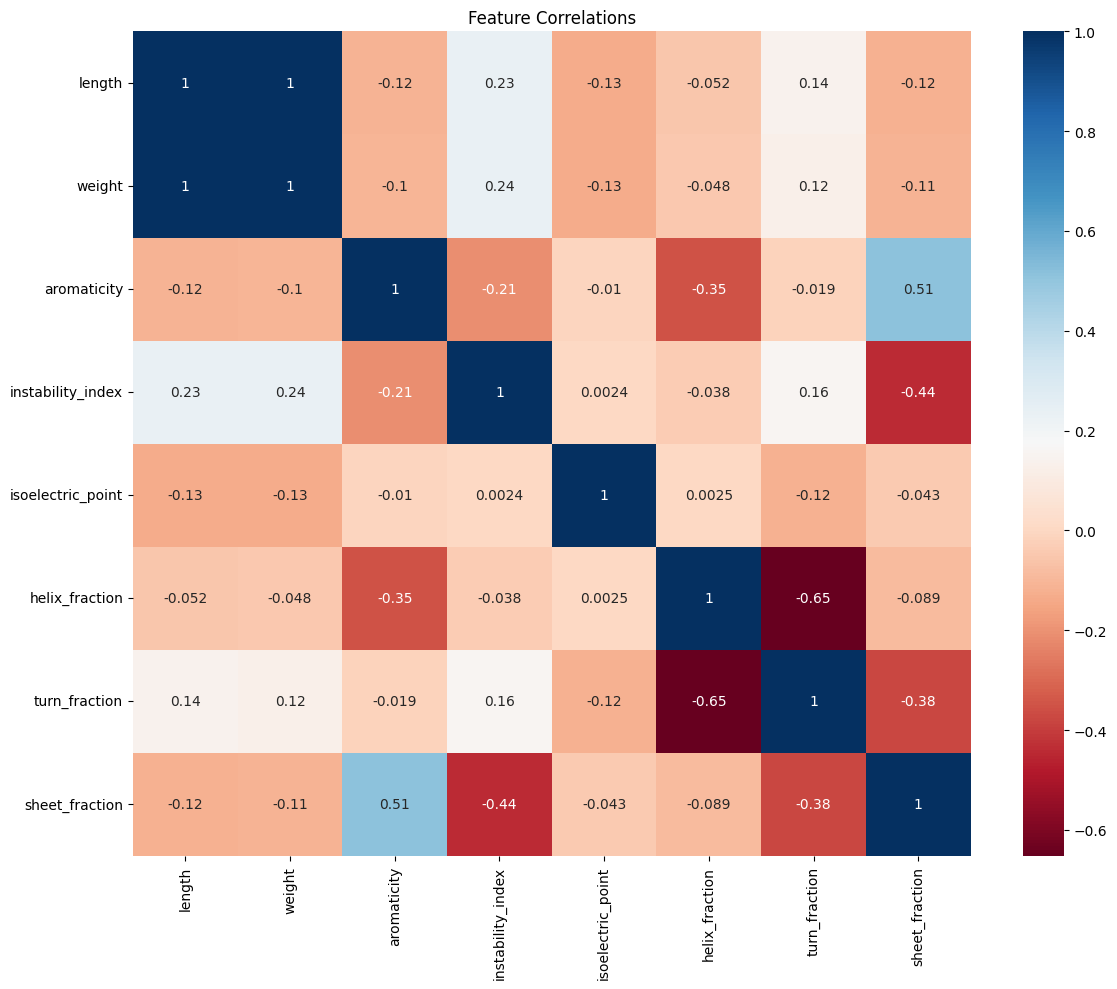

In [15]:
# 特征间相关性热图
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cmap="RdBu")
plt.title("Feature Correlations")
plt.tight_layout()
plt.show()


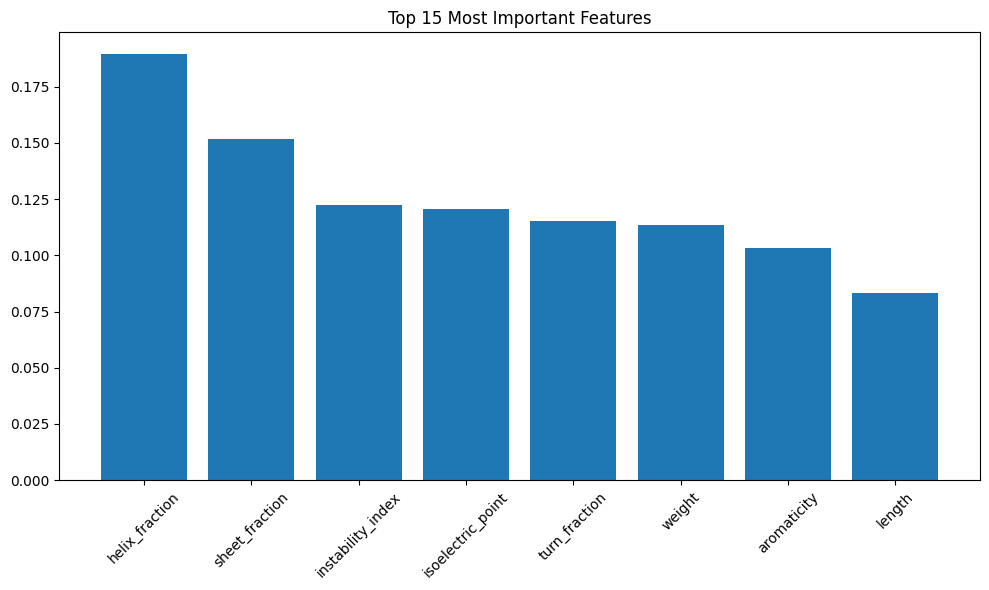

In [16]:
from sklearn.ensemble import RandomForestRegressor

# 使用随机森林评估特征重要性
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# 获取特征重要性
feature_importance = pd.DataFrame(
    {"feature": X.columns, "importance": rf.feature_importances_}
)
feature_importance = feature_importance.sort_values("importance", ascending=False)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.bar(feature_importance["feature"][:15], feature_importance["importance"][:15])
plt.xticks(rotation=45)
plt.title("Top 15 Most Important Features")
plt.tight_layout()
plt.show()


In [17]:
# 计算与目标变量的相关性
correlations = abs(X.corrwith(y)).sort_values(ascending=False)

# 展示相关性最高的特征
print("Top correlated features:")
print(correlations.head(10))


Top correlated features:
aromaticity          0.017289
helix_fraction       0.010096
isoelectric_point    0.005543
sheet_fraction       0.003800
instability_index    0.002807
turn_fraction        0.001882
weight               0.000346
length               0.000009
dtype: float64


In [18]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用LASSO进行特征选择
lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled, y)

# 获取非零系数的特征
selected_features = pd.DataFrame({"feature": X.columns, "coefficient": lasso.coef_})
selected_features = selected_features[selected_features["coefficient"] != 0]
selected_features = selected_features.sort_values(
    "coefficient", key=abs, ascending=False
)
print("\nLASSO selected features:")
print(selected_features)



LASSO selected features:
             feature  coefficient
1             weight    -9.826365
0             length     8.372111
5     helix_fraction     3.181617
6      turn_fraction     1.257281
7     sheet_fraction     1.249599
3  instability_index    -0.571227
4  isoelectric_point     0.292554
2        aromaticity     0.242619


/home/jalen/code/machine_learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.418e+05, tolerance: 4.048e+02
  model = cd_fast.enet_coordinate_descent(


In [19]:
def remove_correlated_features(X, threshold=0.95):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(columns=to_drop), to_drop


# 移除高度相关的特征
X_reduced, dropped_features = remove_correlated_features(X)
print(f"\nDropped features due to high correlation: {dropped_features}")



Dropped features due to high correlation: ['weight']
